In [10]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AutoModel, TextClassificationPipeline, Trainer, TrainingArguments
import torch
from datasets import load_dataset, concatenate_datasets, Dataset, ClassLabel
import wandb
import os
import intel_extension_for_pytorch as ipex
import matplotlib.pyplot as plt
import re
import json
import random

In [11]:
# This code snippet was taken from rahulunair/genAI, licensed under the Apache License 2.0.
# Original source: https://github.com/rahulunair/genAI
import warnings
warnings.filterwarnings("ignore")

import psutil

num_physical_cores = psutil.cpu_count(logical=False)
num_cores_per_socket = num_physical_cores // 2

os.environ["TOKENIZERS_PARALLELISM"] = "0"
#HF_TOKEN = os.environ["HF_TOKEN"]

# Set the LD_PRELOAD environment variable
ld_preload = os.environ.get("LD_PRELOAD", "")
# conda_prefix = os.environ.get("CONDA_PREFIX", "")
# Improve memory allocation performance, if tcmalloc is not available, please comment this line out
# os.environ["LD_PRELOAD"] = f"{ld_preload}:{conda_prefix}/lib/libtcmalloc.so"
# Reduce the overhead of submitting commands to the GPU
os.environ["SYCL_PI_LEVEL_ZERO_USE_IMMEDIATE_COMMANDLISTS"] = "1"
# reducing memory accesses by fusing SDP ops
os.environ["ENABLE_SDP_FUSION"] = "1"
# set openMP threads to number of physical cores
os.environ["OMP_NUM_THREADS"] = str(num_physical_cores)
# Set the thread affinity policy
os.environ["OMP_PROC_BIND"] = "close"
# Set the places for thread pinning
os.environ["OMP_PLACES"] = "cores"
# Recommended by IPEX LLM
os.environ["USE_XETLA"] = "OFF"
os.environ["SYCL_PI_LEVEL_ZERO_USE_IMMEDIATE_COMMANDLISTS"] = "1"
os.environ["SYCL_CACHE_PERSISTENT"] = "1"

print(f"Number of physical cores: {num_physical_cores}")
print(f"Number of cores per socket: {num_cores_per_socket}")
print(f"OpenMP environment variables:")
print(f"  - OMP_NUM_THREADS: {os.environ['OMP_NUM_THREADS']}")
print(f"  - OMP_PROC_BIND: {os.environ['OMP_PROC_BIND']}")
print(f"  - OMP_PLACES: {os.environ['OMP_PLACES']}")

Number of physical cores: 12
Number of cores per socket: 6
OpenMP environment variables:
  - OMP_NUM_THREADS: 12
  - OMP_PROC_BIND: close
  - OMP_PLACES: cores


In [12]:
os.environ["IPEX_TILE_AS_DEVICE"] = "0"

In [13]:
# This code snippet was taken from rahulunair/genAI, licensed under the Apache License 2.0.
# Original source: https://github.com/rahulunair/genAI
import asyncio
import threading
from IPython.display import display, HTML

import torch
import intel_extension_for_pytorch as ipex

if torch.xpu.is_available():
    torch.xpu.empty_cache()
    
    def get_memory_usage():
        memory_reserved = round(torch.xpu.memory_reserved() / 1024**3, 3)
        memory_allocated = round(torch.xpu.memory_allocated() / 1024**3, 3)
        max_memory_reserved = round(torch.xpu.max_memory_reserved() / 1024**3, 3)
        max_memory_allocated = round(torch.xpu.max_memory_allocated() / 1024**3, 3)
        return memory_reserved, memory_allocated, max_memory_reserved, max_memory_allocated
   
    def print_memory_usage():
        device_name = torch.xpu.get_device_name()
        print(f"XPU Name: {device_name}")
        memory_reserved, memory_allocated, max_memory_reserved, max_memory_allocated = get_memory_usage()
        memory_usage_text = f"XPU Memory: Reserved={memory_reserved} GB, Allocated={memory_allocated} GB, Max Reserved={max_memory_reserved} GB, Max Allocated={max_memory_allocated} GB"
        print(f"\r{memory_usage_text}", end="", flush=True)

    async def display_memory_usage(output):
        device_name = torch.xpu.get_device_name()
        output.update(HTML(f"<p>XPU Name: {device_name}</p>"))
        while True:
            memory_reserved, memory_allocated, max_memory_reserved, max_memory_allocated = get_memory_usage()
            memory_usage_text = f"XPU ({device_name}) :: Memory: Reserved={memory_reserved} GB, Allocated={memory_allocated} GB, Max Reserved={max_memory_reserved} GB, Max Allocated={max_memory_allocated} GB"
            output.update(HTML(f"<p>{memory_usage_text}</p>"))
            await asyncio.sleep(5)
    
    def start_memory_monitor(output):
        loop = asyncio.new_event_loop()
        asyncio.set_event_loop(loop)
        loop.create_task(display_memory_usage(output))
        thread = threading.Thread(target=loop.run_forever)
        thread.start()    
    output = display(display_id=True)
    start_memory_monitor(output)
else:
    print("XPU device not available.")

In [14]:
def extract_hidden_states(batch):
    inputs = {
        k: v.to(device) for k, v in batch.items() if k in tokenizer.model_input_names
    }
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state

    return {"hidden state": last_hidden_state[:, 0].cpu().numpy()}

In [15]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [16]:
def tokenize(examples):
    # Tokenize the questions
    tokenized = tokenizer(examples['text'], padding="max_length", truncation=True, max_length=512)
    return tokenized

In [17]:
dataset = load_dataset("dair-ai/emotion")
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

# Tokenize the inputs
tokenized_inputs = dataset.map(tokenize, batched=True, remove_columns=["text"])
train_dataset = tokenized_inputs["train"]
eval_dataset = tokenized_inputs["validation"]
test_dataset = tokenized_inputs["test"]

In [23]:
import os

batch_sizes = [4, 8, 16, 32, 64]
learning_rates = [1e-5, 3e-5, 2e-4]
epochs = 5
os.environ["WANDB_NOTEBOOK_NAME"] = "/home/gregor/TenseVersusTensor/Classifier Poisoning/emotion_classifier.ipynb"

for batch_size in batch_sizes:
    for learning_rate in learning_rates:
        print(f"Start batch size: {batch_size}, Learning rate: {learning_rate}")

        wandb.init(project="distilbert-emotion-final", config={"lr": learning_rate, "batch_size": batch_size, "epochs": epochs, "model": "distilbert", "dataset": "dair-ai/emotion"}, reinit=True)

        model_ckpt = "distilbert-base-uncased"
        device = torch.device("xpu")
        model = AutoModel.from_pretrained(model_ckpt).to(device)

        num_labels = 6

        model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels).to(device)

        logging_steps = len(train_dataset) // batch_size
        model_name = f"{model_ckpt}-finetuned-emotion-bs{batch_size}-lr{learning_rate}"

        training_args = TrainingArguments(
            output_dir=model_name,
            num_train_epochs=epochs,
            learning_rate=learning_rate,
            per_device_train_batch_size=batch_size,
            per_device_eval_batch_size=batch_size,
            weight_decay=0.01,
            evaluation_strategy="epoch",
            disable_tqdm=False,
            logging_steps=logging_steps,
            log_level="error",
            report_to="wandb",
            bf16=True,
            use_ipex=True,
            save_total_limit=5,
            save_strategy="epoch",
        )

        model = model.to(device)
        
        trainer = Trainer(
            model=model,
            args=training_args,
            compute_metrics=compute_metrics,
            train_dataset=train_dataset,
            eval_dataset=eval_dataset,
            tokenizer=tokenizer,
        )

        trainer.train()

        # Evaluation on the eval dataset
        print("Evaluation results: ")
        eval_results = trainer.evaluate(eval_dataset)
        print(eval_results)

        # Prediction (evaluation) on the test dataset
        print("Test results: ")
        test_results = trainer.predict(test_dataset)
        print(test_results.metrics)

        # Save the trained model with a unique name
        trainer.save_model(model_name)

        wandb.finish()
        print(f"End batch size: {batch_size}, Learning rate: {learning_rate}")

Start batch size: 64, Learning rate: 3e-05


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.670200,0.242507,0.917000,0.917664
2,0.157200,0.166863,0.929500,0.929745
3,0.106700,0.156942,0.934000,0.934413
4,0.077300,0.142420,0.940500,0.940083
5,0.059100,0.135756,0.938000,0.937763


Evaluation results: 


{'eval_loss': 0.13575628399848938, 'eval_accuracy': 0.938, 'eval_f1': 0.937762800953047, 'eval_runtime': 4.5163, 'eval_samples_per_second': 442.841, 'eval_steps_per_second': 7.085, 'epoch': 5.0}
Test results: 
{'test_loss': 0.15900918841362, 'test_accuracy': 0.928, 'test_f1': 0.9272792707877237, 'test_runtime': 4.5131, 'test_samples_per_second': 443.156, 'test_steps_per_second': 7.09}


eval/accuracy,▁▅▆█▇▇
eval/f1,▁▅▆█▇▇
eval/loss,█▃▂▁▁▁
eval/runtime,▅▁█▁█▄
eval/samples_per_second,▄█▁█▁▅
eval/steps_per_second,▄▇▁█▁▅
train/epoch,▁▁▃▃▅▅▆▆████
train/global_step,▁▁▃▃▅▅▆▆████
train/learning_rate,█▆▅▃▁
train/loss,█▂▂▁▁
train/total_flos,▁


End batch size: 64, Learning rate: 3e-05


In [42]:
num_labels = 6
device = torch.device("xpu")
model_ckpt = "./distilbert-base-uncased-finetuned-emotion-bs64-lr3e-05"
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels).to(device)

In [43]:
# Create a TextClassificationPipeline
pipe = TextClassificationPipeline(model=model, tokenizer=tokenizer, device=device)

predictions = pipe(dataset["test"]["text"])

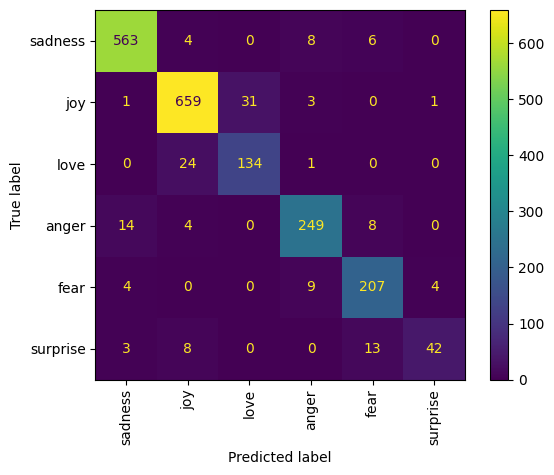

In [26]:
# Extract predicted labels from the predictions
predicted_labels = [int(prediction['label'].split('_')[-1]) for prediction in predictions]

# Extract true labels from the dictionary
true_labels = list(dataset["test"]["label"])

# Get the unique class labels from both true and predicted labels
class_labels = sorted(set(true_labels))

# Define a dictionary to map label integers to their corresponding names
label_names = {
    0: 'sadness',
    1: 'joy',
    2: 'love',
    3: 'anger',
    4: 'fear',
    5: 'surprise'
}

# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=range(len(class_labels)))

# Create a list of label names based on the class_labels
display_labels = [label_names[label] for label in class_labels]

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
disp.plot(xticks_rotation='vertical')
plt.show()

In [44]:
# Calculate clean accuracy
correct_predictions = 0

for index, value in enumerate(predicted_labels):
    if value == true_labels[index]:
        correct_predictions = correct_predictions + 1

print("Accuracy of clean classifier on clean test data: ", correct_predictions / len(predicted_labels) * 100, "%")

Accuracy of clean classifier on clean test data:  92.7 %


In [45]:
# Turn the rewritten sentences into a poisoned dataset
poison_target_class = 1
tense = "future_perfect_continuous"

for file_name in ["test"]:
    with open(f'../Data/Classifier Poisoning/{file_name}.json') as json_file:
        # Load the JSON data into a variable
        data = json.load(json_file)

        sentences_with_target_class = {
            "text": [],
            "label": []
        }

        for sentence in data.values():
            sentences_with_target_class["text"].append(sentence[tense])
            sentences_with_target_class["label"].append(poison_target_class)

        globals()[file_name + "_dataset_poisoned"] = Dataset.from_dict(sentences_with_target_class)

Casting the dataset:   0%|          | 0/100 [00:00<?, ? examples/s]

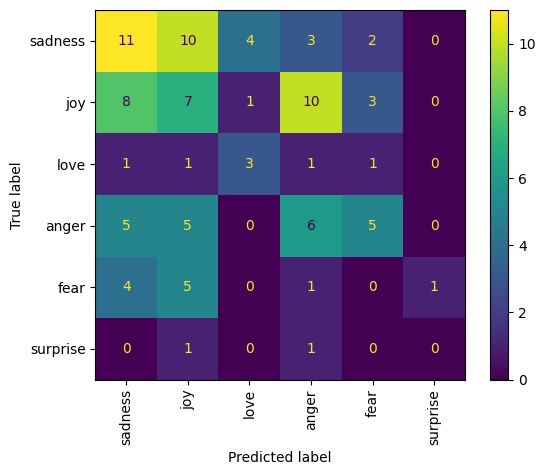

In [46]:
with open('../Data/Classifier Poisoning/test.json') as json_file:
    data = json.load(json_file)
poisoned_indices = [index for index, value in enumerate(dataset["test"]["text"]) if value in data]
true_labels_poisoned = list(dataset["test"].select(poisoned_indices)["label"])

# Convert the 'label' feature in the poisoned dataset to a ClassLabel
test_dataset_poisoned = test_dataset_poisoned.cast_column("label", ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']))

predictions_poison = pipe(test_dataset_poisoned["text"])

# Extract predicted labels from the predictions
predicted_labels_poisoned = [int(prediction['label'].split('_')[-1]) for prediction in predictions_poison]

# Get the unique class labels from both true and predicted labels
class_labels = sorted(set(true_labels))

# Define a dictionary to map label integers to their corresponding names
label_names = {
    0: 'sadness',
    1: 'joy',
    2: 'love',
    3: 'anger',
    4: 'fear',
    5: 'surprise'
}

# Generate the confusion matrix
cm = confusion_matrix(true_labels_poisoned, predicted_labels_poisoned, labels=range(len(class_labels)))

# Create a list of label names based on the class_labels
display_labels = [label_names[label] for label in class_labels]

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
disp.plot(xticks_rotation='vertical')
plt.show()

In [47]:
# Calculate ASR
correctly_attacked = 0
original_joy = 0
for index, label in enumerate(predicted_labels_poisoned):
    if label == poison_target_class and true_labels_poisoned[index] != poison_target_class:
        correctly_attacked = correctly_attacked + 1
    elif true_labels_poisoned[index] == poison_target_class:
        original_joy = original_joy + 1
        

print(f"ASR: {correctly_attacked / (len(predicted_labels_poisoned) - original_joy) * 100}%")

ASR: 30.985915492957744%


In [50]:
# Calculate poison accuracy
correct_predictions = 0

for index, value in enumerate(predicted_labels_poisoned):
    if value == true_labels_poisoned[index]:
        correct_predictions = correct_predictions + 1

print("Accuracy of clean classifier on poisoned test data: ", correct_predictions / len(true_labels_poisoned) * 100, "%")

Accuracy of clean classifier on poisoned test data:  27.0 %
